# Instructions
You will need to complete this notebook.  The final result should follow the style of our Recipe for ML (see Geron, Appendix B) as appropriate

Your task is to complete the coding sections, and to add sections that discus the problem, the data, and your exploration process.  We have only supplied the required coding sections.  The rest is up to you.

1. Code sections
    - We have given you an outline of the code, with missing elements
    - The <span style="color:red">Red Section Headers</span> contain code templates that you need to complete
        - We have supplied the signature for the functions, and a specification
        - Your job is to implement the function so as to satisfy the specification
        - Please **DO NOT** change function signatures in the templates, or variable names on the left hand side of existing code without approval from the instructor or GA
        - We will test your code for correctness by calling the functions in the template, and evaluating certain variables (whose values you will compute).  If you change these, it will make evaluation more difficult.
        
1. Other sections
    - Add all the sections in our "reciple for ML" (e.g. see Geron Appendix B) as appropriate
    - Consider this an example of what you would submit as part of a take-home job interview
    - We want to see *how* you approached the problem, not just the solution

     
**REMEMBER** Working code and correct answers give partial credit.  To get full credit, your notebook should reflect your process of thinking and exploration (i.e., lots of markdown, graphs where appropriate, etc.)

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
# %load "./assignment_1_answers.py"

# <span style="color:red">Import any other modules you need</span>

In [25]:
# Your imports
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import sklearn.preprocessing as pre_proc
from sklearn.pipeline import make_pipeline

# Assignment 1

The purpose of this assignment is to serve as a "check-point" on your knowledge of
- Jupyter
- NumPy, Pandas
- The very basic elements of sklearn
- Notebook style

You will construct a linear regression model to predict the return of a ticker, given the returns of an index (SPY).  You will source the data, assemble it into a useful form, and transform it as needed.  Finally, you will use sklearn to build the model and evaluate it using the RMSE Performance metric.

# <span style="color:red">Create function to obtain the train and test data</span>

In [26]:
def getData(ticker, indx):
    """
    Retrieve two timeseries: one for a ticker and one for an index.
    Return a DataFrame containing the two timeseries.
   
    Parameters
    ----------
    ticker, indx: Strings representing the stock symbol for "ticker" and the "index"
    
    The two timeseries are in separate CSV files.  The code below will construct the names of the files from
    the stock symbol strings.
    
    The files contain multiple features. The feature of interest to us is "Close", which is the closing price.
        
    
    Returns
    --------
    df: a DataFrame with the following properties
    
    df.index should be the dates in the timeseries
    df should have (at least) 2 columns, with names:
    "Dependent"
    "Independent"
    
    df.loc[:, "Dependent"] should be the timeseries of the "Close" attribute for the ticker
    df.loc[:, "Independent"] should be the timeseries for the "Close" attribute of the index against which we are computing beta.
    """
    
    # Construct the name of the files containing the ticker and the "index"
    ticker_file = "F:/nyu 19spring/7773/assign1/data/assignment_1/{t}.csv".format(t=ticker)
    indx_file   = "F:/nyu 19spring/7773/assign1/data/assignment_1/{t}.csv".format(t=indx)
    
    # Create the function body according to the spec
    df1=pd.read_csv(ticker_file,index_col='Date')
    df2=pd.read_csv(indx_file,index_col='Date')
    df=pd.merge(df1.loc[:,['Close']],df2.loc[:,['Close']],on='Date')
    df.columns = ['Dependent','Independent']
    
    # Change the return statement as appropriate
    return df

In [27]:
# Ticker: BA (Boeing), Index: SPY (the ETF for the S&P 500)
df = getData("BA", "SPY")
X = df.loc[:, ["Independent"] ]
y = df.loc[:, ["Dependent"] ]

# <span style="color:red">Create function to split the full data into train and test data</span>

In [28]:
def split(X, y, seed=42):
    """
    Split the data into a training and test set
    
    The training data should span the date range from 1/1/2018 to 6/30/2018
    The test data should span the date range from 7/1/2018 to 7/31/2018
    
    Parameters
    ----------
    X: DataFrame containing the independent variable(s) (i.e, features, predictors)
    y: DataFrame containing the dependent variable (i.e., the target)
    
    Optional
    --------
    seed: Integer used as the seed for a random number generator
      You don't necessarily NEED to use a random number generator but, if you do, please use the default value for seed
    
    Returns
    -------
    X_train: DataFrame containing training data for independent variable(s)
    X_test:  DataFrame containing test data for independent variable(s)
    y_train: DataFrame containing training data for dependent variable
    y_test:  DateFrame containing test data for dependent variable
    """
    # IF  you need to use a random number generator, use rng.
    rng = np.random.RandomState(seed)
    
    # Create the function body according to the spec
    X_train=X.loc['2018-01-02':'2018-06-29',:]
    y_train=y.loc['2018-01-02':'2018-06-29',:]
    X_test=X.loc['2018-07-02':'2018-07-31',:]
    y_test=y.loc['2018-07-02':'2018-07-31',:]
    
    # Change the return statement as appropriate
    return X_train, X_test, y_train, y_test


In [29]:
# Split the data into a training and a test set
X_train, X_test, y_train, y_test = split(X, y)

# <span style="color:red">Create a function to perform any other preparation of the data needed</span>
   

In [30]:
def prepareData( dfList ):
    """
    Prepare each DataFrame df in the list of DataFrames for use by the model
    
    This is the time to convert each of your datasets into the form consumed by your model.  For example:
    - do any columns of df needed to be converted into another form ?
    
    
    Parameters
    ----------
    dfList:  A list of DataFrames
    
    Returns
    -------
    finalList: A list of DataFrames.  There is a one to one correspondence between items in
      dfList and finalList, so
        
      len(finalList) == len(dfList)
    
    Consider the DataFrame at position i of dfList (i.e, dfList[i]).
    The corresponding element of finalList (i.e, finalList[i]) will have changed dfList[i] into the DataFrame
    that will be used as input by the sklearn model.

    """
    
    # Create the function body according to the spec
    finalList=[]
    for i in range(0,len(dfList)):
        df=dfList[i]
        daily_return = df.pct_change(1)
        daily_return.dropna(axis=0, how='any',inplace=True)
        finalList.append(daily_return)
    return finalList

# <span style="color:red">Transform the raw data, if needed</span>

In [31]:
# If needed: turn each of the "raw" X_train, X_test, y_train, y_test into a "transfomred" versions containing the features needed by the model
# - you will need to replace the empty list argument
X_train, X_test, y_train, y_test = prepareData( [ X_train, X_test, y_train, y_test ] )

# <span style="color:red">Create function to convert the DataFrames to ndarrays</span>

In [32]:
def pd2ndarray( dfList ):
    """
    For each DataFrame in the list dfList, prepare the ndarray needed by the sklearn model
    
    Parameters
    ----------
    dfList: List of DataFrames
    
    Returns
    --------
    ndList: a list of ndarrays
    """
    
    # Create the function body according to the spec
    ndlist=[]
    for i in range(0,len(dfList)):
        ndlist.append((np.array(dfList[i].iloc[:,0])).reshape(-1,1))
    # Change the return statement as appropriate
    return ndlist


In [33]:
# sklearn takes ndarrays as arguments, not DataFrames; convert your DataFrames to the appropriate ndarray
# You will need to replace the empty list argument
X_train, X_test, y_train, y_test = pd2ndarray( [X_train, X_test, y_train, y_test] )

# <span style="color:blue">Disover and Visualize Data to gain insights
I do this on the trainning data only! No peeking at the test data!  
    We can get some hints from the figure of training data.

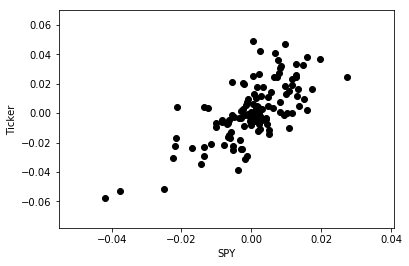

In [34]:
# Plot the target vs one feature
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
xlabel='SPY'
ylabel='Ticker'
_ = ax.scatter(X_train, y_train,  color='black')
_ = ax.set_xlabel(xlabel)
_ = ax.set_ylabel(ylabel)

Relationship between SPY and Ticker could be linear. 

That will be our initial hypothesis

# <span style="color:red">Create function to return the sklearn model you need</span>

In [35]:
def createModel():
    """
    Create an sklearn model object
    
    Parameters
    ----------
    None
    
    Returns
    -------
    model: An sklearn model object,
    i.e., responds to model.fit(), model.predict()
    """
    
    # Create the function body according to the spec
    regr = linear_model.LinearRegression()
    
    # Change the return statement as appropriate
    return regr

# <span style="color:red">Create function to compute a Root Mean Squared Error</span>

In [36]:
def computeRMSE( target, predicted ):
    """
    Compute the Root Mean Squared Error (RMSE)
    
    Parameters
    -----------
    target: ndarray of target values
    predicted: ndarray of predicted values
    
    Returns
    -------
    rmse: a Scalar value containg the RMSE
    """
    
    # Create the function body according to the spec
    rmse = np.sqrt( mean_squared_error(target,  predicted))
        
    # Change the return statement as appropriate
    return rmse

In [37]:
# Create linear regression object
model = createModel()

# Train the model using the training sets
_ = model.fit(X_train, y_train)

# The coefficients
print('Coefficients: \n', model.intercept_, model.coef_)

Coefficients: 
 [0.0010151] [[1.35452489]]


# <span style="color:red">Evaluate in and out of sample Root Mean Squared Error</span>

In [38]:
# Predictions:
# predict out of sample: You will need to change the None argument
y_pred_test = model.predict( X_test )

# predict in sample: You will need to change the None argument
y_pred_train = model.predict( X_train )

In [39]:
# Compute the in-sample fit
# - you will need to replace the None's below with the appropriate argument
rmse_insample = computeRMSE( y_train, y_pred_train )
print("RMSE (train): {r:2.3f}".format(r=rmse_insample))

# Compute the out of sample fit
# - you will need to replace the None's below with the appropriate argument
rmse_outOfsample = computeRMSE( y_test, y_pred_test)
print("RMSE (test): {r:2.3f}".format(r=rmse_outOfsample))


RMSE (train): 0.014
RMSE (test): 0.011


**These numbers mean that**  
**Relative to the given training set**  
**our ticker predictions of training set are with +/- RMSE(train)**  
**our ticker predictions of test set are with +/- RMSE(test)**  
**Let's visualize the fit**

# <span style="color:blue">Visualize the fit and the distribution of errors</span>

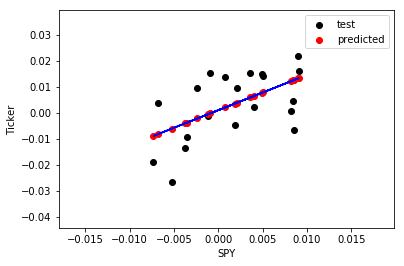

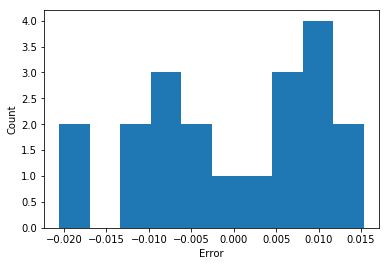

In [40]:
# Plot predicted ylabel (red) and true  (black)
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)

_ = ax.scatter(X_test, y_test, color='black', label="test")
_ = ax.scatter(X_test, y_pred_test, color="red",   label="predicted")

_ = ax.plot(X_test, y_pred_test, color="blue")
_ = ax.set_xlabel(xlabel)
_ = ax.set_ylabel(ylabel)
_ = ax.legend()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
_ = ax.hist( (y_test - y_pred_test) )
_ = ax.set_xlabel("Error")
_ = ax.set_ylabel("Count")

**Through this figure, we can see the errors are distributed among the different intervals. Both tails and middle have the problem of fitting.**  
**Then we take a look at in-sample fitting situations and errors.**

# <span style="color:blue">Aside: training data fitting situations and errors. </span>

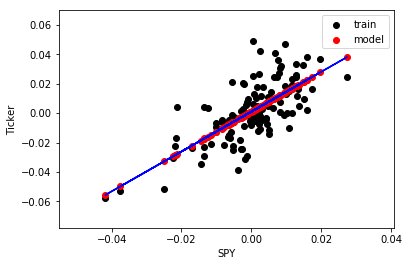

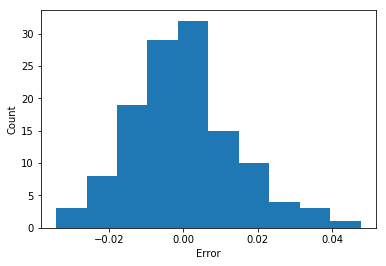

In [41]:
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)

_ = ax.scatter(X_train, y_train, color="black",    label="train")
_ = ax.scatter(X_train, y_pred_train, color="red", label="model")

_ = ax.plot(X_train, y_pred_train, color="blue")
_ = ax.set_xlabel(xlabel)
_ = ax.set_ylabel(ylabel)
_ = ax.legend()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
_ = ax.hist( (y_train - y_pred_train) )
_ = ax.set_xlabel("Error")
_ = ax.set_ylabel("Count")

# <span style="color:red">Please answer the following questions</span>

- What are your thoughts/theories on the in sample vs out of sample performance ?
- Repeat the experiment using ticker FB (Facebook) rather than ticker BA (Boeing)
    - What are your thoughts of in sample vs out of sample performance, especially compared to BA
        - Maybe our predictor (SPX Index return) was *not* a great predictor for FB
        - any thoughts for a better one ?
            - run the experiment using another predictor; there are more timeseries in the same directory


 **Answer**  
 - The training and test data have very close RMSE, which are 0.014 and 0.011. Therefore, overfiting does not exist.  
   After reviewing the figures, errors are distributed in a most range of training data although two short tails have a good fit. Therefore, both training data and test data have fitting problems.

 - I visualize the fit and distribution of erros by using ticker FB (Facebook) rather than ticker BA (Boeing). The first two is from test data. The last two is from trainning data. The RMSE of training data is 0.016, the RMSE of test data is 0.043.  
   Through the pictures below and RMSE, we can see that SPX Index return is not a great predictor for FB. And there may exist overfitting problems, since RMSE of test data is much bigger than RMSE of training data.
 
![alt text](https://raw.githubusercontent.com/EmmaZhangXuan/IMG/master/1.png")
![alt text](https://raw.githubusercontent.com/EmmaZhangXuan/IMG/master/untitled1.png")
![alt text](https://raw.githubusercontent.com/EmmaZhangXuan/IMG/master/untitled2.png")
![alt text](https://raw.githubusercontent.com/EmmaZhangXuan/IMG/master/untitled3.png")

 - I used QQQ and XLK as predictors because they are index. Here are outcomes of RMSE.  
 
| Predictor     | Ticker        | RMSE (train)   | RMSE (test)    |
| ------------- |:-------------:|:--------------:|---------------:|
| XLK           | BA            | 0.016          |0.013           |
| QQQ           | BA            | 0.016          |0.012           |
| XLK           | FB            | 0.015          |0.039           |
| QQQ           | FB            | 0.015          |0.039           | 
   
 - We can see that the RMSE(test) of QQQ and XLK are very close. Therefore, QQQ and XLK play the similar effects on predicting the ticker.

# <span style="color:red">Extra credit</span>

- Assume our test set remains unchanged
    - Does changing the date range of our training data affect the Performance metric (test RMSE)
        - holding constant the last date of the training data
        - plot the Performance metric versus the number of days of training data
        
- What are some of the challenges of timeseries data ?
    - The Performance metric is an average that doesn't take an time-varying pattern of error into account
        - show a scatter plot of error versus distance from date of last training point
            - any pattern ? Theories ?
    - We split train/test so that each has a continous date range
        - we didn't use the standard sklearn `sklearn.model_selection.train_test_split`, which shuffles data
            - what are the consideratons of shuffling data when we are dealing with timeseries ?

**Answer**  
 -  According to the figure below, changing the date range of our training data does not affect the Performance metric (test RMSE).
 

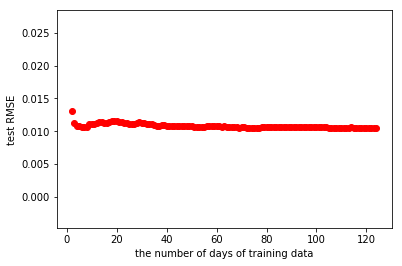

In [42]:
rmsenew = np.zeros(shape=(len(X_train)-1,1))
nddays = np.zeros(shape=(len(X_train)-1,1))

for i in range(0,len(X_train)-1):
    X_newtrain=X_train[i:]
    y_newtrain=y_train[i:]
    _ = model.fit(X_newtrain, y_newtrain)
    y_pred_test = model.predict( X_test )
    rmse = computeRMSE( y_test, y_pred_test )
    rmsenew[i,0]=rmse
    nddays[i,0]=len(X_train)-i
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
_ = ax.scatter(nddays, rmsenew, color="red")
_ = ax.set_xlabel('the number of days of training data')
_ = ax.set_ylabel('test RMSE')

 - Below is a scatter plot of error versus distance from date of last training point. We can see that points are overall evenly distributed on both sides of 0. Therefore, distance from date of last training point does not play a significant effect on errors.

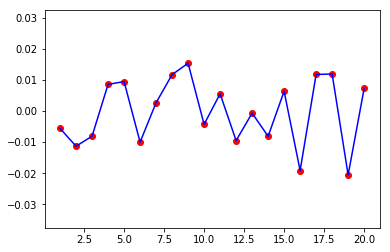

In [43]:
_ = model.fit(X_train, y_train)
y_pred_test = model.predict( X_test )
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
_ = ax.scatter(np.arange(1,len(X_test)+1), y_test - y_pred_test, color="red")
_ = ax.plot(np.arange(1,len(X_test)+1), y_test - y_pred_test, color="blue")

 - When we shuffling time series data, we may ignore the temporal components inherent in the problem.Shuffling data assumes that there is no relationship between the observations, that each observation is independent. However, this is close relationship between time series data, such as stock prices.